In [35]:

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import itertools


# Read in Excel Data
EXCEL_FILE = 'src/results/aggregated_results.xlsx'
#df = pd.read_excel(EXCEL_FILE, sheet_name = 'MIPGAP-10-4')
#df = pd.read_excel(EXCEL_FILE, sheet_name = 'MIPGAP-5x10-4')
df = pd.read_excel(EXCEL_FILE, sheet_name = 'MIPGAP-10x10-4')

# Ensure Relative Gap is numeric and fill NAs with a high value to mark them as invalid

# Generate Instance column and populate

""" def create_name(row):

    return f"Network{row['Network']}.{row['Relaxation']}.{row['Demand']}.{row['Eta']}.{row['Horizon']}.{row['Tau Range']}"

df['Instance'] = df.apply(create_name, axis=1) """

df['Relative Gap'] = pd.to_numeric(df['Relative Gap'], errors='coerce')  # Convert to numeric, coerce bad values to NaN

df['Relative Gap'] = df['Relative Gap'].fillna(999)  # Treat NaNs as invalid by setting a large dummy value


# Filter out instances with any formulation having Relative Gap > 0.005

invalid_instances = df[df['Relative Gap'] > 0.005]['Instance'].unique()

df_filtered = df[~df['Instance'].isin(invalid_instances)].copy()


# Identify all unique formulations

all_formulations = df_filtered['Formulation'].unique()

formulation_counts = df_filtered.groupby('Instance')['Formulation'].nunique()


# Keep only instances that have data from all formulations

complete_instances = formulation_counts[formulation_counts == len(all_formulations)].index

df_filtered = df_filtered[df_filtered['Instance'].isin(complete_instances)].copy()


# Sort instances by minimum time for plotting

instance_order = df_filtered.groupby('Instance')['Time (s)'].min().sort_values().index
print(formulation_counts)

Instance
network_3_0_30_1.2_0.5_10    12
network_3_0_30_1.2_0.6_10    12
network_3_0_30_1.2_0.7_10    12
network_3_0_30_1.4_0.5_10    12
network_3_0_30_1.4_0.6_10    12
network_3_0_30_1.4_0.7_10    12
network_3_0_30_1.6_0.5_10    12
network_3_0_30_1.6_0.6_10    12
network_3_0_30_1.6_0.7_10    12
network_3_0_33_1.2_0.5_10    12
network_3_0_33_1.2_0.6_10    12
network_3_0_33_1.2_0.7_10    12
network_3_0_33_1.4_0.5_10    12
network_3_0_33_1.4_0.6_10    12
network_3_0_33_1.4_0.7_10    12
network_3_0_33_1.6_0.5_10    12
network_3_0_33_1.6_0.6_10    12
network_3_0_33_1.6_0.7_10    12
network_3_0_36_1.2_0.5_10    12
network_3_0_36_1.2_0.6_10    12
network_3_0_36_1.2_0.7_10    12
network_3_0_36_1.4_0.5_10    12
network_3_0_36_1.4_0.6_10    12
network_3_0_36_1.4_0.7_10    12
network_3_0_36_1.6_0.5_10    12
network_3_0_36_1.6_0.6_10    12
network_3_0_36_1.6_0.7_10    12
network_3_0_39_1.2_0.5_10    12
network_3_0_39_1.2_0.6_10    12
network_3_0_39_1.2_0.7_10    12
network_3_0_39_1.4_0.5_10    12

Group Sorted =                       Instance         Formulation  MILP Objective  \
396  network_3_0_36_1.2_0.5_10  F10_UB_X_Task_Unit          4394.0   
397  network_3_0_36_1.2_0.6_10  F10_UB_X_Task_Unit          4256.0   
379  network_3_0_30_1.2_0.6_10  F10_UB_X_Task_Unit          3386.0   
384  network_3_0_30_1.6_0.5_10  F10_UB_X_Task_Unit          3645.0   
386  network_3_0_30_1.6_0.7_10  F10_UB_X_Task_Unit          3333.0   
378  network_3_0_30_1.2_0.5_10  F10_UB_X_Task_Unit          3540.5   
387  network_3_0_33_1.2_0.5_10  F10_UB_X_Task_Unit          3924.5   
403  network_3_0_36_1.6_0.6_10  F10_UB_X_Task_Unit          4449.0   
385  network_3_0_30_1.6_0.6_10  F10_UB_X_Task_Unit          3502.0   
390  network_3_0_33_1.4_0.5_10  F10_UB_X_Task_Unit          4093.0   
398  network_3_0_36_1.2_0.7_10  F10_UB_X_Task_Unit          4137.0   
404  network_3_0_36_1.6_0.7_10  F10_UB_X_Task_Unit          4297.5   
380  network_3_0_30_1.2_0.7_10  F10_UB_X_Task_Unit          3217.0   
389  

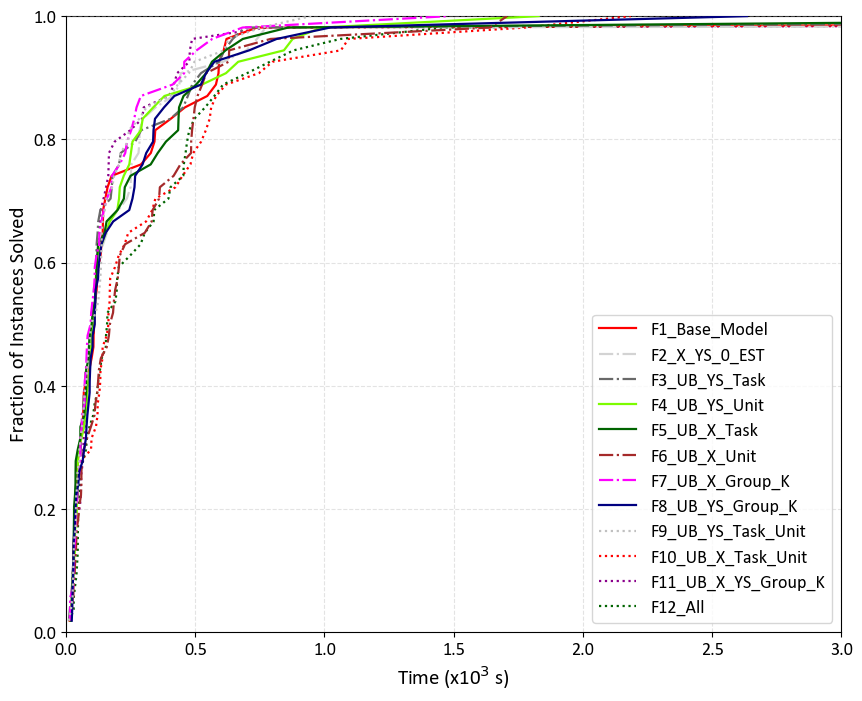

Number of unique instances before filtering: 54
Number of instances used in performance chart: 54


In [36]:


# Create a mapping for instances to y-axis positions

instance_mapping = {inst: i for i, inst in enumerate(instance_order)}

df_filtered['Y Position'] = df_filtered['Instance'].map(instance_mapping)


# Define custom styles for individual formulation curves
formulation_styles = {

    'F1_Base_Model': {'linestyle': 'solid', 'marker': 'o', 'color': 'red'},
    'F2_X_YS_0_EST': {'linestyle': 'dashdot', 'marker': '*', 'color': 'lightgray'},
    'F3_UB_YS_Task': {'linestyle': 'dashdot', 'marker': 'p', 'color': 'dimgray'},
    'F4_UB_YS_Unit': {'linestyle': 'solid', 'marker': 'D', 'color': 'lawngreen'},
    'F5_UB_X_Task': {'linestyle': 'solid', 'marker': 's', 'color': 'darkgreen'},
    'F6_UB_X_Unit': {'linestyle': 'dashdot', 'marker': '^', 'color': 'brown'},
    'F7_UB_X_Group_K': {'linestyle': 'dashdot', 'marker': '+', 'color': 'magenta'},
    'F8_UB_YS_Group_K': {'linestyle': 'solid', 'marker': 'o', 'color': 'navy'},
    'F9_UB_YS_Task_Unit': {'linestyle': 'dotted', 'marker': '*', 'color': 'silver'},
    'F10_UB_X_Task_Unit': {'linestyle': 'dotted', 'marker': 'p', 'color': 'red'},
    'F11_UB_X_YS_Group_K': {'linestyle': 'dotted', 'marker': 'D', 'color': 'darkmagenta'},
    'F12_All': {'linestyle': 'dotted', 'marker': 's', 'color': 'darkgreen'},
    #'F13_UB_X_YS_Group_K': {'linestyle': (0, (3, 5, 1, 5)), 'marker': '^', 'color': 'gold'},
    #'F14_All': {'linestyle': 'solid', 'marker': 'o', 'color': 'darkblue'},
    #'F14_All': {'linestyle': (0, (3, 1, 1, 1)), 'marker': '+', 'color': 'cyan'},

}

formulation_handles = {}

# Desired order of formulations in the legend
desired_legend_order = ['F1_Base_Model', 
                        'F2_X_YS_0_EST', 
                        'F3_UB_YS_Task', 
                        'F4_UB_YS_Unit', 
                        'F5_UB_X_Task', 
                        'F6_UB_X_Unit', 
                        'F7_UB_X_Group_K', 
                        'F8_UB_YS_Group_K', 
                        'F9_UB_YS_Task_Unit', 
                        'F10_UB_X_Task_Unit', 
                        'F11_UB_X_YS_Group_K', 
                        'F12_All'
                        ]

# Map raw formulation names to pretty LaTeX-style labels
legend_labels = {
    'F12_All' : 'F12_All', 
    'F11_UB_X_YS_Group_K' : 'F11_UB_X_YS_Group_K',
    'F10_UB_X_Task_Unit' : 'F10_UB_X_Task_Unit', 
    'F9_UB_YS_Task_Unit' : 'F9_UB_YS_Task_Unit', 
    'F8_UB_YS_Group_K' : 'F8_UB_YS_Group_K', 
    'F7_UB_X_Group_K' : 'F7_UB_X_Group_K', 
    'F6_UB_X_Unit' : 'F6_UB_X_Unit', 
    'F5_UB_X_Task' : 'F5_UB_X_Task', 
    'F4_UB_YS_Unit' : 'F4_UB_YS_Unit', 
    'F3_UB_YS_Task' : 'F3_UB_YS_Task', 
    'F2_X_YS_0_EST' : 'F2_X_YS_0_EST', 
    'F1_Base_Model' : 'F1_Base_Model'
}

plt.figure(figsize=(10, 8))

for formulation, group in df_filtered.groupby('Formulation'):

    group_sorted = group.sort_values(by='Time (s)')  # Sort each formulation's data by time
    print(f'Group Sorted = {group_sorted}')
    total_instances = len(instance_order)
    print(f'Total Instances = {total_instances}')
    y_positions = (np.arange(len(group_sorted)) + 1) / total_instances  # Normalize to [0, 1]
    print(f'Y positions = {y_positions}')
    style = formulation_styles.get(formulation, {'linestyle': '-', 'marker': 'o', 'color': 'red'})

    

    line, = plt.plot(group_sorted['Time (s)'] /1000,

        y_positions,

        linestyle=style['linestyle'],

        # marker=style['marker'],

        color=style['color'],                 # Set the line color

        markerfacecolor=style['color'],       # Explicitly set marker face color

        markeredgecolor=style['color'],       # Explicitly set marker edge color

        markersize=5,                         # Reduced marker size

        linewidth=1.6,                          # Increase line thickness here

        label=legend_labels.get(formulation, formulation))

    formulation_handles[formulation] = line


# Set other plot properties

axis_number_size = 13

axis_label_size = 15

font_family = 'calibri'


plt.xlabel(r'Time (x10$^3$ s)', fontdict={'family': font_family, 'size': axis_label_size})

plt.ylabel("Fraction of Instances Solved", fontdict={'family': font_family, 'size': axis_label_size})

plt.xticks(fontsize=axis_number_size, fontname=font_family)

plt.yticks(fontsize=axis_number_size, fontname=font_family)

plt.tick_params(axis='x', labelsize=axis_number_size)

plt.tick_params(axis='y', labelsize=axis_number_size)

#plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

#plt.title('Performance Chart', fontdict={'family': font_family, 'size': 16, 'weight': 'bold'})

plt.grid(True, linestyle='--', alpha=0.35)

#plt.xscale('log')

plt.xlim(0, 3)

plt.ylim(0, 1.00)

top_spine = plt.gca().spines['top']

top_spine.set_zorder(0)  # Move behind the plot lines


# Filter for only the formulations that were actually plotted

ordered_handles = [

    formulation_handles[form] for form in desired_legend_order if form in formulation_handles

]

ordered_labels = [

    legend_labels[form] for form in desired_legend_order if form in formulation_handles

]

# Apply ordered legend

plt.legend(ordered_handles, ordered_labels,

           loc='lower right', prop={'family': font_family, 'size': axis_number_size})

#plt.legend(loc='lower right', title='Formulation', prop={'family': font_family, 'size': axis_number_size})

plt.show()


print(f"Number of unique instances before filtering: {df['Instance'].nunique()}")

print(f"Number of instances used in performance chart: {len(instance_order)}")

# %%
